In [1]:
from __future__ import annotations
from typing import Optional, Tuple, Dict, Any

from torch.utils.data import DataLoader

from src.types.task_protocol import TaskProtocol
from src.datasets.esc50.esc50_dataset2 import make_esc50_loaders

class ESC50Task(TaskProtocol):
    problem_type: str = "multiclass"

    def make_loaders(
        self,
        data_root: str,
        batch_size: int,
        **kwargs: Any,
    ) -> Tuple[DataLoader, DataLoader, Optional[DataLoader]]:

        train_loader, val_loader, test_loader = make_esc50_loaders(
            data_root=data_root,
            batch_size=batch_size,
            num_workers=kwargs.get("num_workers", 4),
            fold_val=kwargs["fold_val"],
            feature=kwargs["feature"],
            sample_rate=kwargs["sample_rate"],
            n_mels=kwargs["n_mels"],
            hop_length=kwargs["hop_length"],
            n_fft=kwargs["n_fft"],
            target_num_frames=kwargs["target_num_frames"],
            augment=kwargs.get("augment", True),
            download=kwargs.get("download", False),
        )
        return train_loader, val_loader, test_loader

    def infer_input_dim(self, args: Dict[str, Any]) -> int:
        return args["n_mels"] if args.get("feature", "melspec") == "melspec" else 1

    def infer_num_classes(self, args: Dict[str, Any]) -> int:
        return 50

    def infer_theta(self, args: Dict[str, Any]) -> int:
        # sequence length for LMU/S4 block config
        return int(args["target_num_frames"])


In [2]:
from pathlib import Path

import torch
from src.train_utils.trainer import Trainer
from src.models.v2.build_model import BlockConfig, build_model

# ----- Resolve data roots like your previous script -----
current_dir = Path.cwd()
project_root = current_dir.parent.parent.parent
data_root = str(project_root / "src" / "datasets" / "esc50" / "data")

def create_block_cfg_ctor(dropout: float, mlp_ratio: float, droppath_final: float,
                          layerscale_init: float, residual_gain: float, pool: str):
    """Create a block config constructor with the given hyperparameters."""
    def block_cfg_ctor(theta: int) -> BlockConfig:
        return BlockConfig(
            kind="lmu",
            memory_size=256,
            theta=theta,
            dropout=dropout,
            mlp_ratio=mlp_ratio,
            droppath_final=droppath_final,
            layerscale_init=layerscale_init,
            residual_gain=residual_gain,
            pool=pool,
        )
    return block_cfg_ctor

def main() -> None:
    task = ESC50Task()

    # Share the same knobs you already used
    args: Dict[str, Any] = {
        # data
        "data_root": str(data_root),
        "batch": 32,
        "data_loader_kwargs": {
            "num_workers": 4,
            "fold_val": 1,
            "feature": "melspec",
            "sample_rate": 16000,
            "n_mels": 128,
            "hop_length": 160,
            "n_fft": 512,
            "target_num_frames": 500,
            "augment": True,
            "download": False,
        },

        # training
        "epochs": 100,
        "lr": 3e-4,
        "wd": 1e-3,
        "amp": True,
        "save_dir": "./runs/esc50_task",
        "label_smoothing": 0.1,
        "warmup_epochs": 5,
        "patience": 30,
        "min_delta": 0.0,

        # model scaffold
        "d_model": 256,
        "depth": 6,
        "dropout": 0.2,
        "mlp_ratio": 2.0,
        "droppath_final": 0.1,
        "layerscale_init": 1e-2,
        "residual_gain": 1.0,
        "pool": "mean",
    }

    args["block_cfg_ctor"] = create_block_cfg_ctor(
        dropout=args["dropout"],
        mlp_ratio=args["mlp_ratio"],
        droppath_final=args["droppath_final"],
        layerscale_init=args["layerscale_init"],
        residual_gain=args["residual_gain"],
        pool=args["pool"],
    )


    # Optional: set device explicitly or let Trainer pick it
    if torch.cuda.is_available():
        args["device"] = torch.device("cuda")
    elif torch.backends.mps.is_available():
        args["device"] = torch.device("mps")
    else:
        args["device"] = torch.device("cpu")

    trainer = Trainer(args=args, task=task, model_builder=build_model)
    best_metric, ckpt_path = trainer.fit()
    print(f"Done. Best {trainer.early_key}={best_metric:.4f} @ {ckpt_path}")
    return trainer

In [3]:
trainer = main()

ESC-50 check under /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/datasets/esc50/data. Checking /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/datasets/esc50/data/ESC-50-master ...


/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


ESC-50 check under /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/datasets/esc50/data. Checking /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/datasets/esc50/data/ESC-50-master ...


/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: divide by zero encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: overflow encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: invalid value encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: divide by zero encountered in matmul
  eAw = eAw @ eAw
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/li

new best acc 0.0125
Epoch 000/100 | train 3.9986/0.0125 | val 3.9570/0.0125 | t 25.6s/3.0s | lr 3.00e-07


new best acc 0.0325
Epoch 001/100 | train 3.9267/0.0250 | val 3.7657/0.0325 | t 22.6s/1.9s | lr 6.02e-05


new best acc 0.0600
Epoch 002/100 | train 3.8176/0.0369 | val 3.6005/0.0600 | t 22.5s/1.9s | lr 1.20e-04


new best acc 0.0800
Epoch 003/100 | train 3.7199/0.0494 | val 3.4992/0.0800 | t 22.4s/1.9s | lr 1.80e-04


/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 004/100 | train 3.5661/0.0725 | val 3.4493/0.0800 | t 22.5s/1.9s | lr 2.40e-04


new best acc 0.1450
Epoch 005/100 | train 3.4347/0.1087 | val 3.4092/0.1450 | t 23.1s/2.1s | lr 3.00e-04


new best acc 0.1600
Epoch 006/100 | train 3.3186/0.1181 | val 3.3765/0.1600 | t 24.7s/2.2s | lr 3.00e-04


Epoch 007/100 | train 3.2791/0.1437 | val 3.4302/0.1225 | t 26.5s/2.4s | lr 3.00e-04


new best acc 0.1775
Epoch 008/100 | train 3.2286/0.1619 | val 3.3633/0.1775 | t 29.2s/2.5s | lr 2.99e-04


Epoch 009/100 | train 3.2008/0.1581 | val 3.3226/0.1650 | t 28.3s/2.5s | lr 2.99e-04


new best acc 0.2000
Epoch 010/100 | train 3.1444/0.1844 | val 3.2965/0.2000 | t 28.1s/2.4s | lr 2.98e-04


Epoch 011/100 | train 3.1327/0.1925 | val 3.2933/0.2000 | t 28.1s/2.4s | lr 2.97e-04


Epoch 012/100 | train 3.0875/0.2119 | val 3.2523/0.1900 | t 28.0s/2.4s | lr 2.96e-04


Epoch 013/100 | train 3.0681/0.2131 | val 3.2072/0.2000 | t 27.9s/2.5s | lr 2.95e-04


new best acc 0.2125
Epoch 014/100 | train 3.0273/0.2306 | val 3.2469/0.2125 | t 28.4s/2.5s | lr 2.93e-04


Epoch 015/100 | train 2.9912/0.2338 | val 3.2301/0.2050 | t 28.2s/2.5s | lr 2.92e-04


Epoch 016/100 | train 2.9771/0.2512 | val 3.1971/0.1750 | t 28.4s/2.4s | lr 2.90e-04


Epoch 017/100 | train 2.9522/0.2469 | val 3.1950/0.2050 | t 28.5s/2.5s | lr 2.88e-04


new best acc 0.2375
Epoch 018/100 | train 2.9006/0.2669 | val 3.1470/0.2375 | t 28.8s/2.6s | lr 2.86e-04


Epoch 019/100 | train 2.9240/0.2581 | val 3.1243/0.2350 | t 28.7s/2.5s | lr 2.84e-04


Epoch 020/100 | train 2.8571/0.2812 | val 3.0818/0.2375 | t 28.8s/2.5s | lr 2.82e-04


Epoch 021/100 | train 2.8167/0.2994 | val 3.0287/0.2275 | t 28.9s/2.5s | lr 2.79e-04


new best acc 0.2500
Epoch 022/100 | train 2.7904/0.3094 | val 3.0413/0.2500 | t 29.2s/2.6s | lr 2.77e-04


new best acc 0.2625
Epoch 023/100 | train 2.7595/0.3137 | val 3.0235/0.2625 | t 28.9s/2.5s | lr 2.74e-04


new best acc 0.2800
Epoch 024/100 | train 2.7444/0.3237 | val 3.0036/0.2800 | t 28.7s/2.5s | lr 2.71e-04


new best acc 0.2825
Epoch 025/100 | train 2.6875/0.3275 | val 2.9684/0.2825 | t 28.8s/2.5s | lr 2.68e-04


Epoch 026/100 | train 2.6761/0.3513 | val 2.9090/0.2825 | t 29.1s/2.5s | lr 2.65e-04


Epoch 027/100 | train 2.6306/0.3588 | val 2.9229/0.2750 | t 28.8s/2.5s | lr 2.62e-04


new best acc 0.3075
Epoch 028/100 | train 2.6047/0.3831 | val 2.9231/0.3075 | t 28.9s/2.5s | lr 2.59e-04


Epoch 029/100 | train 2.5683/0.3906 | val 2.8816/0.2975 | t 29.0s/2.6s | lr 2.55e-04


new best acc 0.3100
⏹ Early stopping (patience=30, best=0.3100).
Done. Best acc=0.3100 @ ./runs/esc50_task/best.pt


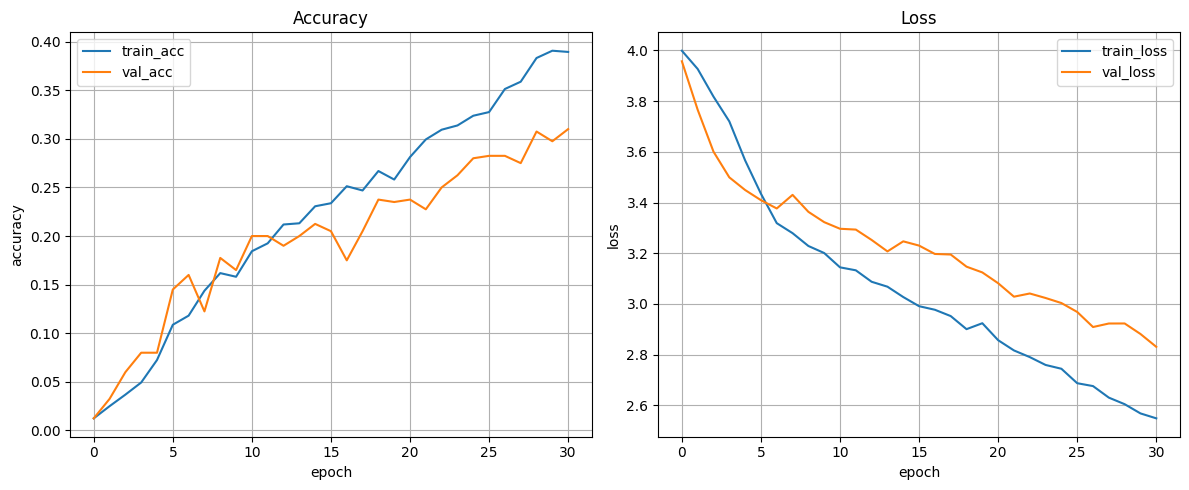

In [4]:
# Plot training history
import matplotlib.pyplot as plt

history = trainer.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()

ESC-50 check under /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/datasets/esc50/data. Checking /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/datasets/esc50/data/ESC-50-master ...


/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


ESC-50 check under /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/datasets/esc50/data. Checking /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/datasets/esc50/data/ESC-50-master ...


/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: divide by zero encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: overflow encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: invalid value encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: divide by zero encountered in matmul
  eAw = eAw @ eAw
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/li

Loaded checkpoint from epoch 30
Val metrics: {'loss': 2.83093111038208, 'time_s': 2.5756952500000807, 'acc': 0.31}


/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.o


Overall accuracy: 0.3100


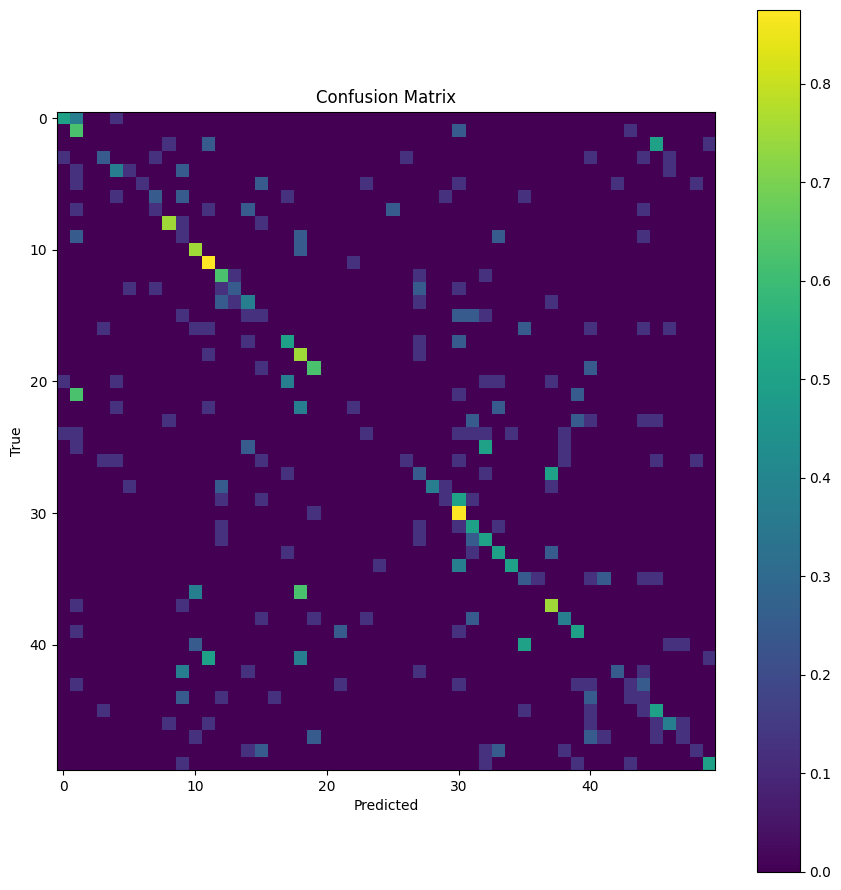


Top per-class accuracies:
01. class_30                  : 0.875
02. class_11                  : 0.875
03. class_10                  : 0.750
04. class_37                  : 0.750
05. class_18                  : 0.750
06. class_8                   : 0.750
07. class_1                   : 0.625
08. class_19                  : 0.625
09. class_12                  : 0.625
10. class_49                  : 0.500
Bottom per-class accuracies:
01. class_36                  : 0.000
02. class_2                   : 0.000
03. class_23                  : 0.000
04. class_6                   : 0.000
05. class_16                  : 0.000
06. class_41                  : 0.000
07. class_40                  : 0.000
08. class_20                  : 0.000
09. class_21                  : 0.000
10. class_5                   : 0.000


In [5]:
# Evaluation and Visualization
import os
import torch
import matplotlib.pyplot as plt
from src.eval.infer import predict_loader
from src.eval.metrics import confusion_matrix
from src.eval.report import print_basic_report, plot_confusion, print_per_class
from src.utils.common import amp_autocast

# Get the trainer from the last run (we need to store it)
# For now, let's create a simple evaluation function
def evaluate_best_model():
    """Load best checkpoint and evaluate on validation set."""
    task = ESC50Task()

    # Recreate data loaders
    _, val_loader, _ = task.make_loaders(
        data_root=data_root,
        batch_size=32,
        num_workers=4,
        fold_val=1,
        feature="melspec",
        sample_rate=16000,
        n_mels=128,
        hop_length=160,
        n_fft=512,
        target_num_frames=500,
        augment=False,  # No augmentation for evaluation
        download=False,
    )

    # Load best checkpoint
    best_ckpt_path = "./runs/esc50_task/best.pt"
    if not os.path.exists(best_ckpt_path):
        print(f"Checkpoint not found at {best_ckpt_path}")
        return

    best_ckpt = torch.load(best_ckpt_path, map_location="cpu")

    # Recreate model
    from src.models.v2.build_model import BlockConfig, build_model

    d_in = 128  # n_mels
    n_classes = 50
    theta = 500  # target_num_frames

    block_cfg = BlockConfig(
        kind="lmu",
        memory_size=256,
        theta=theta,
        dropout=0.2,
        mlp_ratio=2.0,
        droppath_final=0.1,
        layerscale_init=1e-2,
        residual_gain=1.0,
        pool="mean",
    )

    model = build_model(
        d_in=d_in,
        n_classes=n_classes,
        d_model=256,
        depth=6,
        block_cfg=block_cfg,
    )

    # Load weights
    model.load_state_dict(best_ckpt["model"])

    # Set device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    model.to(device)
    amp = device.type in {"cuda", "mps"}

    print(f"Loaded checkpoint from epoch {best_ckpt['epoch']}")
    print(f"Val metrics: {best_ckpt['val']}")

    # Get predictions
    logits, labels = predict_loader(model, val_loader, device, amp_autocast, amp)

    # Print basic report
    print("\n" + "="*50)
    print_basic_report(logits, labels)

    # Confusion matrix
    cm = confusion_matrix(logits, labels, num_classes=50)
    plot_confusion(cm, class_names=None, normalize=True, figsize=(9, 9))
    plt.show()

    # Per-class accuracies
    print("\n" + "="*50)
    print_per_class(cm, class_names=None, top_k=10)

evaluate_best_model()